<a href="https://colab.research.google.com/github/henryfuentesbenito/TFM/blob/main/dNRI_particle_interaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Instalar bibliotecas necesarias
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
# Clonar el repositorio
!git clone https://github.com/cgraber/cvpr_dNRI.git

Cloning into 'cvpr_dNRI'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 116 (delta 18), reused 12 (delta 12), pack-reused 90 (from 1)
Receiving objects: 100% (116/116), 457.07 KiB | 9.52 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
# Cambiar al directorio del repositorio clonado
%cd cvpr_dNRI

/content/cvpr_dNRI


In [ ]:
# Instalar cualquier otro requerimiento si es necesario
!pip install -e ./

Obtaining file:///content/cvpr_dNRI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for dnri


In [ ]:
import os

# Definir las rutas
DATA_PATH = '/content/drive/MyDrive/datos/'
BASE_RESULTS_DIR = '/content/drive/MyDrive/results/'

In [ ]:
SEED=1

In [ ]:
WORKING_DIR=f"{BASE_RESULTS_DIR}nri/seed_{SEED}/"
ENCODER_ARGS='--num_edge_types 2 --encoder_hidden 256 --skip_first --encoder_mlp_hidden 256 --encoder_mlp_num_layers 3'
DECODER_ARGS=''
MODEL_ARGS=f"--model_type nri --graph_type static {ENCODER_ARGS} {DECODER_ARGS} --seed {SEED}"
TRAINING_ARGS='--no_edge_prior 0.9 --batch_size 16 --lr 5e-4 --use_adam --num_epochs 200 --lr_decay_factor 0.5 --lr_decay_steps 200 --normalize_kl --normalize_nll --tune_on_nll --val_teacher_forcing --teacher_forcing_steps -1'

In [ ]:
WORKING_DIR

'/content/drive/MyDrive/results/nri/seed_1/'

In [ ]:
mkdir -p $WORKING_DIR

In [ ]:
from dnri.utils.flags import build_flags
import dnri.models.model_builder as model_builder
from dnri.datasets.small_synth_data import SmallSynthData
import dnri.training.train as train
import dnri.training.train_utils as train_utils
import dnri.training.evaluate as evaluate
import dnri.utils.misc as misc

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torch

import os
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt, matplotlib.animation as animation, matplotlib.colors as mcolors
import numpy as np

def eval_edges(model, dataset, params):

    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1000)
    eval_metric = params.get('eval_metric')
    num_edge_types = params['num_edge_types']
    skip_first = params['skip_first']
    data_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=gpu)
    full_edge_count = 0.
    model.eval()
    correct_edges = 0.
    edge_count = 0.
    correct_0_edges = 0.
    edge_0_count = 0.
    correct_1_edges = 0.
    edge_1_count = 0.

    correct = num_predicted = num_gt = 0
    all_edges = []
    for batch_ind, batch in enumerate(data_loader):
        inputs = batch['inputs']
        gt_edges = batch['edges'].long()
        with torch.no_grad():
            if gpu:
                inputs = inputs.cuda(non_blocking=True)
                gt_edges = gt_edges.cuda(non_blocking=True)

            _, _, _, edges, _ = model.calculate_loss(inputs, is_train=False, return_logits=True)
            edges = edges.argmax(dim=-1)
            all_edges.append(edges.cpu())
            if len(edges.shape) == 3 and len(gt_edges.shape) == 2:
                gt_edges = gt_edges.unsqueeze(1).expand(gt_edges.size(0), edges.size(1), gt_edges.size(1))
            elif len(gt_edges.shape) == 3 and len(edges.shape) == 2:
                edges = edges.unsqueeze(1).expand(edges.size(0), gt_edges.size(1), edges.size(1))
            if edges.size(1) == gt_edges.size(1) - 1:
                gt_edges = gt_edges[:, :-1]
            edge_count += edges.numel()
            full_edge_count += gt_edges.numel()
            correct_edges += ((edges == gt_edges)).sum().item()
            edge_0_count += (gt_edges == 0).sum().item()
            edge_1_count += (gt_edges == 1).sum().item()
            correct_0_edges += ((edges == gt_edges)*(gt_edges == 0)).sum().item()
            correct_1_edges += ((edges == gt_edges)*(gt_edges == 1)).sum().item()
            correct += (edges*gt_edges).sum().item()
            num_predicted += edges.sum().item()
            num_gt += gt_edges.sum().item()
    prec = correct / (num_predicted + 1e-8)
    rec = correct / (num_gt + 1e-8)
    f1 = 2*prec*rec / (prec+rec+1e-6)
    all_edges = torch.cat(all_edges)
    return f1, correct_edges / (full_edge_count + 1e-8), correct_0_edges / (edge_0_count + 1e-8), correct_1_edges / (edge_1_count + 1e-8), all_edges

def plot_sample(model, dataset, num_samples, params):
    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1)
    use_gt_edges = params.get('use_gt_edges')
    data_loader = DataLoader(dataset, batch_size=batch_size)
    model.eval()
    batch_count = 0
    all_errors = []
    burn_in_steps = 10
    forward_pred_steps = 40
    for batch_ind, batch in enumerate(data_loader):
        inputs = batch['inputs']
        gt_edges = batch.get('edges', None)
        with torch.no_grad():
            model_inputs = inputs[:, :burn_in_steps]
            gt_predictions = inputs[:, burn_in_steps:burn_in_steps+forward_pred_steps]
            if gpu:
                model_inputs = model_inputs.cuda(non_blocking=True)
                if gt_edges is not None and use_gt_edges:
                    gt_edges = gt_edges.cuda(non_blocking=True)
            if not use_gt_edges:
                gt_edges=None
            model_preds = model.predict_future(model_inputs, forward_pred_steps).cpu()
            #total_se += F.mse_loss(model_preds, gt_predictions).item()
            print("MSE: ", torch.nn.functional.mse_loss(model_preds, gt_predictions).item())
            batch_count += 1
        fig, ax = plt.subplots()
        unnormalized_preds = dataset.unnormalize(model_preds)
        unnormalized_gt = dataset.unnormalize(inputs)
        def update(frame):
            ax.clear()
            ax.plot(unnormalized_gt[0, frame, 0, 0], unnormalized_gt[0, frame, 0, 1], 'bo')
            ax.plot(unnormalized_gt[0, frame, 1, 0], unnormalized_gt[0, frame, 1, 1], 'ro')
            ax.plot(unnormalized_gt[0, frame, 2, 0], unnormalized_gt[0, frame, 2, 1], 'go')
            if frame >= burn_in_steps:
                tmp_fr = frame - burn_in_steps
                ax.plot(unnormalized_preds[0, tmp_fr, 0, 0], unnormalized_preds[0, tmp_fr, 0, 1], 'bo', alpha=0.5)
                ax.plot(unnormalized_preds[0, tmp_fr, 1, 0], unnormalized_preds[0, tmp_fr, 1, 1], 'ro', alpha=0.5)
                ax.plot(unnormalized_preds[0, tmp_fr, 2, 0], unnormalized_preds[0, tmp_fr, 2, 1], 'go', alpha=0.5)
            ax.set_xlim(-6, 6)
            ax.set_ylim(-6, 6)
        ani = animation.FuncAnimation(fig, update, interval=100, frames=burn_in_steps+forward_pred_steps)
        path = os.path.join(params['working_dir'], 'pred_trajectory_%d.mp4'%batch_ind)
        ani.save(path, codec='mpeg4')
        if batch_count >= num_samples:
            break

In [ ]:
import argparse

In [ ]:
parser = argparse.ArgumentParser('')
parser.add_argument('--working_dir', required=True)
parser.add_argument('--gpu', action='store_true')
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--mode', choices=['train', 'eval', 'eval_fixedwindow'], required=True)
parser.add_argument('--load_model')
parser.add_argument('--load_best_model', action='store_true')
parser.add_argument('--continue_training', action='store_true')
parser.add_argument('--model_type', choices=['nri', 'dnri', 'fc_baseline'])

# Training Params
parser.add_argument('--num_epochs', type=int)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--mom', type=float, default=0)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--sub_batch_size', type=int)
parser.add_argument('--val_batch_size', type=int)
parser.add_argument('--val_interval', type=int, default=5)
parser.add_argument('--test', action='store_true')
parser.add_argument('--use_adam', action='store_true')
parser.add_argument('--lr_decay_factor', type=float)
parser.add_argument('--lr_decay_steps', type=int)
parser.add_argument('--clip_grad_norm', type=float)
parser.add_argument('--verbose', action='store_true')
parser.add_argument('--tune_on_nll', action='store_true')
parser.add_argument('--val_teacher_forcing', action='store_true')
parser.add_argument('--accumulate_steps', type=int, default=1)
parser.add_argument('--max_burn_in_count', type=int, default=-1)

# Model Params
parser.add_argument('--no_prior', action='store_true')
parser.add_argument('--avg_prior', action='store_true')
parser.add_argument('--add_uniform_prior', action='store_true')
parser.add_argument('--prior_num_layers', type=int, default=1)
parser.add_argument('--prior_hidden_size', type=int, default=256)
parser.add_argument('--use_learned_prior', action='store_true')
parser.add_argument('--graph_type', choices=['static', 'dynamic'])
parser.add_argument('--avg_encoder_inputs', action='store_true')
parser.add_argument('--use_dynamic_graph', action='store_true')
parser.add_argument('--use_static_encoder', action='store_true')
parser.add_argument('--decoder_type')
parser.add_argument('--encoder_rnn_type', choices=['lstm', 'gru'], default='lstm')
parser.add_argument('--decoder_rnn_type', choices=['lstm', 'gru'], default='gru')
parser.add_argument('--encoder_hidden', type=int, default=256)
parser.add_argument('--encoder_rnn_hidden', type=int)
parser.add_argument('--num_edge_types', type=int, default=2)
parser.add_argument('--encoder_dropout', type=float, default=0.0)
parser.add_argument('--encoder_unidirectional', action='store_true')
parser.add_argument('--encoder_bidirectional', action='store_true')
parser.add_argument('--encoder_no_factor', action='store_true', default=False)
parser.add_argument('--decoder_hidden', type=int, default=256)
parser.add_argument('--decoder_msg_hidden', type=int, default=256)
parser.add_argument('--decoder_dropout', type=float, default=0.0)
parser.add_argument('--skip_first', action='store_true', default=False)
parser.add_argument('--uniform_prior', action='store_true')
parser.add_argument('--no_edge_prior', type=float)
parser.add_argument('--teacher_forcing_steps', type=int, default=10)
parser.add_argument('--gumbel_temp', type=float, default=0.5)
parser.add_argument('--train_hard_sample', action='store_true')
parser.add_argument('--normalize_kl', action='store_true')
parser.add_argument('--normalize_kl_per_var', action='store_true')
parser.add_argument('--normalize_nll', action='store_true')
parser.add_argument('--normalize_nll_per_var', action='store_true')
parser.add_argument('--kl_coef', type=float, default=1.)
parser.add_argument('--no_encoder_bn', action='store_true')
parser.add_argument('--encoder_mlp_hidden', type=int, default=256)
parser.add_argument('--encoder_mlp_num_layers', type=int, default=1)
parser.add_argument('--rnn_hidden', type=int, default=64)
parser.add_argument('--teacher_forcing_prior', action='store_true')
parser.add_argument('--decoder_rnn_hidden', type=int)
parser.add_argument('--encoder_save_eval_memory', action='store_true')
parser.add_argument('--encoder_normalize_mode', choices=[None, 'normalize_inp', 'normalize_all'])
parser.add_argument('--normalize_inputs', action='store_true')
parser.add_argument('--data_path')
parser.add_argument('--same_data_norm', action='store_true')
parser.add_argument('--no_data_norm', action='store_true')
parser.add_argument('--error_out_name', default='prediction_errors_%dstep.npy')
parser.add_argument('--prior_variance', type=float, default=5e-5)
parser.add_argument('--test_burn_in_steps', type=int, default=10)
parser.add_argument('--error_suffix')
parser.add_argument('--subject_ind', type=int, default=-1)

_StoreAction(option_strings=['--subject_ind'], dest='subject_ind', nargs=None, const=None, default=-1, type=<class 'int'>, choices=None, required=False, help=None, metavar=None)

In [ ]:
args = parser.parse_args(f'--mode train --data_path {DATA_PATH} --working_dir {WORKING_DIR} {MODEL_ARGS} {TRAINING_ARGS}'.split()); args

Namespace(working_dir='/content/drive/MyDrive/results/nri/seed_1/', gpu=False, seed=1, mode='train', load_model=None, load_best_model=False, continue_training=False, model_type='nri', num_epochs=200, lr=0.0005, mom=0, batch_size=16, sub_batch_size=None, val_batch_size=None, val_interval=5, test=False, use_adam=True, lr_decay_factor=0.5, lr_decay_steps=200, clip_grad_norm=None, verbose=False, tune_on_nll=True, val_teacher_forcing=True, accumulate_steps=1, max_burn_in_count=-1, no_prior=False, avg_prior=False, add_uniform_prior=False, prior_num_layers=1, prior_hidden_size=256, use_learned_prior=False, graph_type='static', avg_encoder_inputs=False, use_dynamic_graph=False, use_static_encoder=False, decoder_type=None, encoder_rnn_type='lstm', decoder_rnn_type='gru', encoder_hidden=256, encoder_rnn_hidden=None, num_edge_types=2, encoder_dropout=0.0, encoder_unidirectional=False, encoder_bidirectional=False, encoder_no_factor=False, decoder_hidden=256, decoder_msg_hidden=256, decoder_dropout

In [ ]:
params = vars(args);params

{'working_dir': '/content/drive/MyDrive/results/nri/seed_1/',
 'gpu': False,
 'seed': 1,
 'mode': 'train',
 'load_model': None,
 'load_best_model': False,
 'continue_training': False,
 'model_type': 'nri',
 'num_epochs': 200,
 'lr': 0.0005,
 'mom': 0,
 'batch_size': 16,
 'sub_batch_size': None,
 'val_batch_size': None,
 'val_interval': 5,
 'test': False,
 'use_adam': True,
 'lr_decay_factor': 0.5,
 'lr_decay_steps': 200,
 'clip_grad_norm': None,
 'verbose': False,
 'tune_on_nll': True,
 'val_teacher_forcing': True,
 'accumulate_steps': 1,
 'max_burn_in_count': -1,
 'no_prior': False,
 'avg_prior': False,
 'add_uniform_prior': False,
 'prior_num_layers': 1,
 'prior_hidden_size': 256,
 'use_learned_prior': False,
 'graph_type': 'static',
 'avg_encoder_inputs': False,
 'use_dynamic_graph': False,
 'use_static_encoder': False,
 'decoder_type': None,
 'encoder_rnn_type': 'lstm',
 'decoder_rnn_type': 'gru',
 'encoder_hidden': 256,
 'encoder_rnn_hidden': None,
 'num_edge_types': 2,
 'encoder_

In [ ]:
misc.seed(args.seed) # set seed for numpy torch cuda and random libs

In [ ]:
params['num_vars'] = 3
params['input_size'] = 4
params['input_time_steps'] = 50
params['nll_loss_type'] = 'gaussian'
train_data = SmallSynthData(args.data_path, 'train', params)
val_data   = SmallSynthData(args.data_path, 'val', params)

In [ ]:
model = model_builder.build_model(params)

Using factor graph MLP encoder.
ENCODER:  RefMLPEncoder(
  (mlp1): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=200, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
    )
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp2): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
    )
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp3): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
 

In [ ]:
params['gpu']

False

In [ ]:
if args.mode == 'train':
    with train_utils.build_writers(args.working_dir) as (train_writer, val_writer):
        train.train(model, train_data, val_data, params, train_writer, val_writer)

EPOCH 1 0
BEST VAL RESULT. SAVING MODEL...
EPOCH 1 EVAL: 
	CURRENT VAL LOSS: 2.109163
	BEST VAL LOSS:    2.109163
	BEST VAL EPOCH:   1
EPOCH 2 5.906940698623657
BEST VAL RESULT. SAVING MODEL...
EPOCH 2 EVAL: 
	CURRENT VAL LOSS: 0.809939
	BEST VAL LOSS:    0.809939
	BEST VAL EPOCH:   2
EPOCH 3 3.8602466583251953
EPOCH 3 EVAL: 
	CURRENT VAL LOSS: 1.362719
	BEST VAL LOSS:    0.809939
	BEST VAL EPOCH:   2
EPOCH 4 3.7527668476104736
BEST VAL RESULT. SAVING MODEL...
EPOCH 4 EVAL: 
	CURRENT VAL LOSS: 0.753977
	BEST VAL LOSS:    0.753977
	BEST VAL EPOCH:   4
EPOCH 5 4.864334344863892
BEST VAL RESULT. SAVING MODEL...
EPOCH 5 EVAL: 
	CURRENT VAL LOSS: -0.006269
	BEST VAL LOSS:    -0.006269
	BEST VAL EPOCH:   5
EPOCH 6 4.691205739974976
BEST VAL RESULT. SAVING MODEL...
EPOCH 6 EVAL: 
	CURRENT VAL LOSS: -0.412187
	BEST VAL LOSS:    -0.412187
	BEST VAL EPOCH:   6
EPOCH 7 3.8450722694396973
EPOCH 7 EVAL: 
	CURRENT VAL LOSS: -0.366136
	BEST VAL LOSS:    -0.412187
	BEST VAL EPOCH:   6
EPOCH 8 3.782532

In [ ]:
#if args.mode == 'eval':
test_data = SmallSynthData(args.data_path, 'test', params)
forward_pred = 50 - args.test_burn_in_steps
test_mse  = evaluate.eval_forward_prediction(model, test_data, args.test_burn_in_steps, forward_pred, params)
path = os.path.join(args.working_dir, args.error_out_name%args.test_burn_in_steps)
np.save(path, test_mse.cpu().numpy())
test_mse_1  = test_mse[0].item()
test_mse_15 = test_mse[14].item()
test_mse_25 = test_mse[24].item()
print("FORWARD PRED RESULTS:")
print("\t1 STEP: ", test_mse_1)
print("\t15 STEP: ",test_mse_15)
print("\t25 STEP: ",test_mse_25)


f1, all_acc, acc_0, acc_1, edges = eval_edges(model, val_data, params)
print("Val Edge results:")
print("\tF1: ",f1)
print("\tAll predicted edge accuracy: ",all_acc)
print("\tFirst Edge Acc: ",acc_0)
print("\tSecond Edge Acc: ",acc_1)
out_dir = os.path.join(args.working_dir, 'preds')
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'encoder_edges.npy')
np.save(out_path, edges.numpy())

plot_sample(model, test_data, args.test_burn_in_steps, params)

FORWARD PRED RESULTS:
	1 STEP:  0.00010658917017281055
	15 STEP:  0.02248053066432476
	25 STEP:  0.03390005975961685
Val Edge results:
	F1:  0.28491291520204165
	All predicted edge accuracy:  0.9064666666663644
	First Edge Acc:  0.9272088003895679
	Second Edge Acc:  0.4387755102006376
MSE:  0.025221118703484535
MSE:  0.03121432289481163
MSE:  0.026759441941976547
MSE:  0.05606646463274956
MSE:  0.031724411994218826
MSE:  0.025016406551003456
MSE:  0.029462609440088272


In [ ]:
! --test_burn_in_steps 25

/bin/bash: line 1: --test_burn_in_steps: command not found


In [ ]:
args = parser.parse_args(f'--mode eval --test_burn_in_steps 25 --load_best_model --data_path {DATA_PATH} --working_dir {WORKING_DIR} {MODEL_ARGS} {TRAINING_ARGS}'.split()); args

Namespace(working_dir='/content/drive/MyDrive/results/nri/seed_1/', gpu=False, seed=1, mode='eval', load_model=None, load_best_model=True, continue_training=False, model_type='nri', num_epochs=200, lr=0.0005, mom=0, batch_size=16, sub_batch_size=None, val_batch_size=None, val_interval=5, test=False, use_adam=True, lr_decay_factor=0.5, lr_decay_steps=200, clip_grad_norm=None, verbose=False, tune_on_nll=True, val_teacher_forcing=True, accumulate_steps=1, max_burn_in_count=-1, no_prior=False, avg_prior=False, add_uniform_prior=False, prior_num_layers=1, prior_hidden_size=256, use_learned_prior=False, graph_type='static', avg_encoder_inputs=False, use_dynamic_graph=False, use_static_encoder=False, decoder_type=None, encoder_rnn_type='lstm', decoder_rnn_type='gru', encoder_hidden=256, encoder_rnn_hidden=None, num_edge_types=2, encoder_dropout=0.0, encoder_unidirectional=False, encoder_bidirectional=False, encoder_no_factor=False, decoder_hidden=256, decoder_msg_hidden=256, decoder_dropout=0

In [ ]:
params = vars(args);params

{'working_dir': '/content/drive/MyDrive/results/nri/seed_1/',
 'gpu': False,
 'seed': 1,
 'mode': 'eval',
 'load_model': None,
 'load_best_model': True,
 'continue_training': False,
 'model_type': 'nri',
 'num_epochs': 200,
 'lr': 0.0005,
 'mom': 0,
 'batch_size': 16,
 'sub_batch_size': None,
 'val_batch_size': None,
 'val_interval': 5,
 'test': False,
 'use_adam': True,
 'lr_decay_factor': 0.5,
 'lr_decay_steps': 200,
 'clip_grad_norm': None,
 'verbose': False,
 'tune_on_nll': True,
 'val_teacher_forcing': True,
 'accumulate_steps': 1,
 'max_burn_in_count': -1,
 'no_prior': False,
 'avg_prior': False,
 'add_uniform_prior': False,
 'prior_num_layers': 1,
 'prior_hidden_size': 256,
 'use_learned_prior': False,
 'graph_type': 'static',
 'avg_encoder_inputs': False,
 'use_dynamic_graph': False,
 'use_static_encoder': False,
 'decoder_type': None,
 'encoder_rnn_type': 'lstm',
 'decoder_rnn_type': 'gru',
 'encoder_hidden': 256,
 'encoder_rnn_hidden': None,
 'num_edge_types': 2,
 'encoder_dr

In [ ]:
misc.seed(args.seed) # set seed for numpy torch cuda and random libs

In [ ]:
params['num_vars'] = 3
params['input_size'] = 4
params['input_time_steps'] = 50
params['nll_loss_type'] = 'gaussian'
train_data = SmallSynthData(args.data_path, 'train', params)
val_data   = SmallSynthData(args.data_path, 'val', params)

In [ ]:
model = model_builder.build_model(params)

Using factor graph MLP encoder.
ENCODER:  RefMLPEncoder(
  (mlp1): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=200, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
    )
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp2): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
    )
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp3): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
 

In [ ]:
if args.mode == 'eval':
    test_data = SmallSynthData(args.data_path, 'test', params)
    forward_pred = 50 - args.test_burn_in_steps
    test_mse  = evaluate.eval_forward_prediction(model, test_data, args.test_burn_in_steps, forward_pred, params)
    path = os.path.join(args.working_dir, args.error_out_name%args.test_burn_in_steps)
    np.save(path, test_mse.cpu().numpy())
    test_mse_1  = test_mse[0].item()
    test_mse_15 = test_mse[14].item()
    test_mse_25 = test_mse[24].item()
    print("FORWARD PRED RESULTS:")
    print("\t1 STEP: ", test_mse_1)
    print("\t15 STEP: ",test_mse_15)
    print("\t25 STEP: ",test_mse_25)


    f1, all_acc, acc_0, acc_1, edges = eval_edges(model, val_data, params)
    print("Val Edge results:")
    print("\tF1: ",f1)
    print("\tAll predicted edge accuracy: ",all_acc)
    print("\tFirst Edge Acc: ",acc_0)
    print("\tSecond Edge Acc: ",acc_1)
    out_dir = os.path.join(args.working_dir, 'preds_eval_best_25')
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, 'encoder_edges.npy')
    np.save(out_path, edges.numpy())

    plot_sample(model, test_data, args.test_burn_in_steps, params)

FORWARD PRED RESULTS:
	1 STEP:  2.123346166627016e-05
	15 STEP:  0.0019051118288189173
	25 STEP:  0.004750142805278301
Val Edge results:
	F1:  0.26911271132856346
	All predicted edge accuracy:  0.9043999999996986
	First Edge Acc:  0.9261296386545547
	Second Edge Acc:  0.4144427001537328
MSE:  0.01916656084358692
MSE:  0.024596022441983223
MSE:  0.016913970932364464
MSE:  0.030282994732260704
MSE:  0.021424787119030952
MSE:  0.016158444806933403
MSE:  0.03058360330760479


In [ ]:
if args.mode == 'record_predictions':
    model.eval()
    burn_in = args.test_burn_in_steps
    forward_pred = 50 - args.test_burn_in_steps
    test_data = SmallSynthData(args.data_path, 'test', params)
    if args.subject_ind == -1:
        val_data_loader = DataLoader(test_data, batch_size=params['batch_size'])
        all_predictions = []
        all_edges = []
        for batch_ind,batch in enumerate(val_data_loader):
            print("BATCH %d of %d"%(batch_ind+1, len(val_data_loader)))
            inputs = batch['inputs']
            if args.gpu:
                inputs = inputs.cuda(non_blocking=True)
            with torch.no_grad():
                predictions, edges = model.predict_future(inputs[:, :burn_in], forward_pred, return_edges=True, return_everything=True)
                all_predictions.append(predictions)
                all_edges.append(edges)
        if args.error_suffix is not None:
            out_path = os.path.join(args.working_dir, 'preds/', 'all_test_subjects_%s.npy'%args.error_suffix)
        else:
            out_path = os.path.join(args.working_dir, 'preds/', 'all_test_subjects.npy')

        predictions = torch.cat(all_predictions, dim=0)
        edges = torch.cat(all_edges, dim=0)

    else:
        data = test_data[args.subject_ind]
        inputs = data['inputs'].unsqueeze(0)
        if args.gpu:
            inputs = inputs.cuda(non_blocking=True)
        with torch.no_grad():
            predictions, edges = model.predict_future(inputs[:, :burn_in], forward_pred, return_edges=True, return_everything=True)
            predictions = predictions.squeeze(0)
            edges = edges.squeeze(0)
        out_path = os.path.join(args.working_dir, 'preds/', 'subject_%d.npy'%args.subject_ind)
    tmp_dir = os.path.join(args.working_dir, 'preds/')
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)
    torch.save([predictions.cpu(), edges.cpu()], out_path)

**DNRI**


In [ ]:
WORKING_DIR=f"{BASE_RESULTS_DIR}dnri/seed_{SEED}/"
ENCODER_ARGS="--encoder_hidden 256 --encoder_mlp_num_layers 3 --encoder_mlp_hidden 128 --encoder_rnn_hidden 64"
DECODER_ARGS="--decoder_hidden 256 --decoder_type ref_mlp"
HIDDEN_ARGS="--rnn_hidden 64"
PRIOR_ARGS="--use_learned_prior --prior_num_layers 3 --prior_hidden_size 128"
MODEL_ARGS=f"--model_type dnri --graph_type dynamic --skip_first --num_edge_types 2 {ENCODER_ARGS} {DECODER_ARGS} {HIDDEN_ARGS} {PRIOR_ARGS} --seed {SEED}"
TRAINING_ARGS='--add_uniform_prior --no_edge_prior 0.9 --batch_size 16 --lr 5e-4 --use_adam --num_epochs 200 --lr_decay_factor 0.5 --lr_decay_steps 200 --normalize_kl --normalize_nll --tune_on_nll --val_teacher_forcing --teacher_forcing_steps -1'

In [ ]:
args = parser.parse_args(f'--mode train --data_path {DATA_PATH} --working_dir {WORKING_DIR} {MODEL_ARGS} {TRAINING_ARGS}'.split()); args

Namespace(working_dir='/content/drive/MyDrive/results/dnri/seed_1/', gpu=False, seed=1, mode='train', load_model=None, load_best_model=False, continue_training=False, model_type='dnri', num_epochs=200, lr=0.0005, mom=0, batch_size=16, sub_batch_size=None, val_batch_size=None, val_interval=5, test=False, use_adam=True, lr_decay_factor=0.5, lr_decay_steps=200, clip_grad_norm=None, verbose=False, tune_on_nll=True, val_teacher_forcing=True, accumulate_steps=1, max_burn_in_count=-1, no_prior=False, avg_prior=False, add_uniform_prior=True, prior_num_layers=3, prior_hidden_size=128, use_learned_prior=True, graph_type='dynamic', avg_encoder_inputs=False, use_dynamic_graph=False, use_static_encoder=False, decoder_type='ref_mlp', encoder_rnn_type='lstm', decoder_rnn_type='gru', encoder_hidden=256, encoder_rnn_hidden=64, num_edge_types=2, encoder_dropout=0.0, encoder_unidirectional=False, encoder_bidirectional=False, encoder_no_factor=False, decoder_hidden=256, decoder_msg_hidden=256, decoder_dro

In [ ]:
params = vars(args);params

{'working_dir': '/content/drive/MyDrive/results/dnri/seed_1/',
 'gpu': False,
 'seed': 1,
 'mode': 'train',
 'load_model': None,
 'load_best_model': False,
 'continue_training': False,
 'model_type': 'dnri',
 'num_epochs': 200,
 'lr': 0.0005,
 'mom': 0,
 'batch_size': 16,
 'sub_batch_size': None,
 'val_batch_size': None,
 'val_interval': 5,
 'test': False,
 'use_adam': True,
 'lr_decay_factor': 0.5,
 'lr_decay_steps': 200,
 'clip_grad_norm': None,
 'verbose': False,
 'tune_on_nll': True,
 'val_teacher_forcing': True,
 'accumulate_steps': 1,
 'max_burn_in_count': -1,
 'no_prior': False,
 'avg_prior': False,
 'add_uniform_prior': True,
 'prior_num_layers': 3,
 'prior_hidden_size': 128,
 'use_learned_prior': True,
 'graph_type': 'dynamic',
 'avg_encoder_inputs': False,
 'use_dynamic_graph': False,
 'use_static_encoder': False,
 'decoder_type': 'ref_mlp',
 'encoder_rnn_type': 'lstm',
 'decoder_rnn_type': 'gru',
 'encoder_hidden': 256,
 'encoder_rnn_hidden': 64,
 'num_edge_types': 2,
 'enco

In [ ]:
misc.seed(args.seed) # set seed for numpy torch cuda and random libs

In [ ]:
params['num_vars'] = 3
params['input_size'] = 4
params['input_time_steps'] = 50
params['nll_loss_type'] = 'gaussian'
train_data = SmallSynthData(args.data_path, 'train', params)
val_data   = SmallSynthData(args.data_path, 'val', params)

In [ ]:
model = model_builder.build_model(params)

Using learned interaction net decoder.
USING NO EDGE PRIOR:  tensor([[[-0.1054, -2.3026]]])
dNRI MODEL:  DNRI(
  (encoder): DNRI_Encoder(
    (mlp1): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=4, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp2): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp3): RefNRIMLP(
      (mo

In [ ]:
if args.mode == 'train':
    with train_utils.build_writers(args.working_dir) as (train_writer, val_writer):
        train.train(model, train_data, val_data, params, train_writer, val_writer)

EPOCH 1 0
BEST VAL RESULT. SAVING MODEL...
EPOCH 1 EVAL: 
	CURRENT VAL LOSS: 1.383601
	BEST VAL LOSS:    1.383601
	BEST VAL EPOCH:   1
EPOCH 2 8.701972961425781
BEST VAL RESULT. SAVING MODEL...
EPOCH 2 EVAL: 
	CURRENT VAL LOSS: -0.283971
	BEST VAL LOSS:    -0.283971
	BEST VAL EPOCH:   2
EPOCH 3 6.496497631072998
BEST VAL RESULT. SAVING MODEL...
EPOCH 3 EVAL: 
	CURRENT VAL LOSS: -0.305005
	BEST VAL LOSS:    -0.305005
	BEST VAL EPOCH:   3
EPOCH 4 8.156956672668457
BEST VAL RESULT. SAVING MODEL...
EPOCH 4 EVAL: 
	CURRENT VAL LOSS: -0.313773
	BEST VAL LOSS:    -0.313773
	BEST VAL EPOCH:   4
EPOCH 5 6.677062749862671
BEST VAL RESULT. SAVING MODEL...
EPOCH 5 EVAL: 
	CURRENT VAL LOSS: -0.585780
	BEST VAL LOSS:    -0.585780
	BEST VAL EPOCH:   5
EPOCH 6 8.408665418624878
BEST VAL RESULT. SAVING MODEL...
EPOCH 6 EVAL: 
	CURRENT VAL LOSS: -0.700710
	BEST VAL LOSS:    -0.700710
	BEST VAL EPOCH:   6
EPOCH 7 6.600669622421265
BEST VAL RESULT. SAVING MODEL...
EPOCH 7 EVAL: 
	CURRENT VAL LOSS: -0.7176

In [ ]:
#if args.mode == 'eval':
test_data = SmallSynthData(args.data_path, 'test', params)
forward_pred = 50 - args.test_burn_in_steps
test_mse  = evaluate.eval_forward_prediction(model, test_data, args.test_burn_in_steps, forward_pred, params)
path = os.path.join(args.working_dir, args.error_out_name%args.test_burn_in_steps)
np.save(path, test_mse.cpu().numpy())
test_mse_1  = test_mse[0].item()
test_mse_15 = test_mse[14].item()
test_mse_25 = test_mse[24].item()
print("FORWARD PRED RESULTS:")
print("\t1 STEP: ", test_mse_1)
print("\t15 STEP: ",test_mse_15)
print("\t25 STEP: ",test_mse_25)


f1, all_acc, acc_0, acc_1, edges = eval_edges(model, val_data, params)
print("Val Edge results:")
print("\tF1: ",f1)
print("\tAll predicted edge accuracy: ",all_acc)
print("\tFirst Edge Acc: ",acc_0)
print("\tSecond Edge Acc: ",acc_1)
out_dir = os.path.join(args.working_dir, 'preds')
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'encoder_edges.npy')
np.save(out_path, edges.numpy())

plot_sample(model, test_data, args.test_burn_in_steps, params)

FORWARD PRED RESULTS:
	1 STEP:  0.00012391609197948128
	15 STEP:  0.026994721964001656
	25 STEP:  0.03485015034675598
Val Edge results:
	F1:  0.6159691038095376
	All predicted edge accuracy:  0.9725170068023903
	First Edge Acc:  0.9934937959963759
	Second Edge Acc:  0.5090337784720422
MSE:  0.03326752036809921
MSE:  0.030963309109210968
MSE:  0.01859257183969021
MSE:  0.027361633256077766
MSE:  0.012471616268157959
MSE:  0.018234288319945335
MSE:  0.019530829042196274


<ipython-input-11-30936ab70676>:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


**Eval best**

In [ ]:
args = parser.parse_args(f'--mode eval --load_best_model --data_path {DATA_PATH} --working_dir {WORKING_DIR} {MODEL_ARGS} {TRAINING_ARGS}'.split()); args

Namespace(working_dir='/content/drive/MyDrive/results/dnri/seed_1/', gpu=False, seed=1, mode='eval', load_model=None, load_best_model=True, continue_training=False, model_type='dnri', num_epochs=200, lr=0.0005, mom=0, batch_size=16, sub_batch_size=None, val_batch_size=None, val_interval=5, test=False, use_adam=True, lr_decay_factor=0.5, lr_decay_steps=200, clip_grad_norm=None, verbose=False, tune_on_nll=True, val_teacher_forcing=True, accumulate_steps=1, max_burn_in_count=-1, no_prior=False, avg_prior=False, add_uniform_prior=True, prior_num_layers=3, prior_hidden_size=128, use_learned_prior=True, graph_type='dynamic', avg_encoder_inputs=False, use_dynamic_graph=False, use_static_encoder=False, decoder_type='ref_mlp', encoder_rnn_type='lstm', decoder_rnn_type='gru', encoder_hidden=256, encoder_rnn_hidden=64, num_edge_types=2, encoder_dropout=0.0, encoder_unidirectional=False, encoder_bidirectional=False, encoder_no_factor=False, decoder_hidden=256, decoder_msg_hidden=256, decoder_dropo

In [ ]:
params = vars(args);params

{'working_dir': '/content/drive/MyDrive/results/dnri/seed_1/',
 'gpu': False,
 'seed': 1,
 'mode': 'eval',
 'load_model': None,
 'load_best_model': True,
 'continue_training': False,
 'model_type': 'dnri',
 'num_epochs': 200,
 'lr': 0.0005,
 'mom': 0,
 'batch_size': 16,
 'sub_batch_size': None,
 'val_batch_size': None,
 'val_interval': 5,
 'test': False,
 'use_adam': True,
 'lr_decay_factor': 0.5,
 'lr_decay_steps': 200,
 'clip_grad_norm': None,
 'verbose': False,
 'tune_on_nll': True,
 'val_teacher_forcing': True,
 'accumulate_steps': 1,
 'max_burn_in_count': -1,
 'no_prior': False,
 'avg_prior': False,
 'add_uniform_prior': True,
 'prior_num_layers': 3,
 'prior_hidden_size': 128,
 'use_learned_prior': True,
 'graph_type': 'dynamic',
 'avg_encoder_inputs': False,
 'use_dynamic_graph': False,
 'use_static_encoder': False,
 'decoder_type': 'ref_mlp',
 'encoder_rnn_type': 'lstm',
 'decoder_rnn_type': 'gru',
 'encoder_hidden': 256,
 'encoder_rnn_hidden': 64,
 'num_edge_types': 2,
 'encode

In [ ]:
misc.seed(args.seed) # set seed for numpy torch cuda and random libs

In [ ]:
params['num_vars'] = 3
params['input_size'] = 4
params['input_time_steps'] = 50
params['nll_loss_type'] = 'gaussian'
train_data = SmallSynthData(args.data_path, 'train', params)
val_data   = SmallSynthData(args.data_path, 'val', params)

In [ ]:
model = model_builder.build_model(params)

Using learned interaction net decoder.
USING NO EDGE PRIOR:  tensor([[[-0.1054, -2.3026]]])
dNRI MODEL:  DNRI(
  (encoder): DNRI_Encoder(
    (mlp1): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=4, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp2): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp3): RefNRIMLP(
      (mo

In [ ]:
if args.mode == 'eval':
    test_data = SmallSynthData(args.data_path, 'test', params)
    forward_pred = 50 - args.test_burn_in_steps
    test_mse  = evaluate.eval_forward_prediction(model, test_data, args.test_burn_in_steps, forward_pred, params)
    path = os.path.join(args.working_dir, args.error_out_name%args.test_burn_in_steps)
    np.save(path, test_mse.cpu().numpy())
    test_mse_1  = test_mse[0].item()
    test_mse_15 = test_mse[14].item()
    test_mse_25 = test_mse[24].item()
    print("FORWARD PRED RESULTS:")
    print("\t1 STEP: ", test_mse_1)
    print("\t15 STEP: ",test_mse_15)
    print("\t25 STEP: ",test_mse_25)


    f1, all_acc, acc_0, acc_1, edges = eval_edges(model, val_data, params)
    print("Val Edge results:")
    print("\tF1: ",f1)
    print("\tAll predicted edge accuracy: ",all_acc)
    print("\tFirst Edge Acc: ",acc_0)
    print("\tSecond Edge Acc: ",acc_1)
    out_dir = os.path.join(args.working_dir, 'preds')
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, 'encoder_edges.npy')
    np.save(out_path, edges.numpy())

    plot_sample(model, test_data, args.test_burn_in_steps, params)

FORWARD PRED RESULTS:
	1 STEP:  0.00010179352102568373
	15 STEP:  0.025014378130435944
	25 STEP:  0.032938361167907715
Val Edge results:
	F1:  0.5909762324539021
	All predicted edge accuracy:  0.9719387755098735
	First Edge Acc:  0.9947381519532852
	Second Edge Acc:  0.4681853888415697
MSE:  0.024372613057494164
MSE:  0.036975909024477005
MSE:  0.02883647009730339
MSE:  0.03650031238794327
MSE:  0.025631828233599663
MSE:  0.021745318546891212
MSE:  0.015820661559700966


**Manual inspection of best model DNRI**

In [ ]:
evaluate.eval_forward_prediction??

In [ ]:
eval_edges??

In [ ]:
!pip install dnri  # Make sure the dnri package is installed

import dnri  # Import the dnri module

In [ ]:
model = dnri.models.dnri.DNRI(params)

Using learned interaction net decoder.
USING NO EDGE PRIOR:  tensor([[[-0.1054, -2.3026]]])


In [ ]:
path

NameError: name 'path' is not defined

In [ ]:
print("LOADING BEST MODEL")
path = os.path.join("/content/drive/MyDrive/results/dnri/seed_1/", 'best_model')
print(path)
model.load(path)

LOADING BEST MODEL
/content/drive/MyDrive/results/dnri/seed_1/best_model


In [ ]:
model

DNRI(
  (encoder): DNRI_Encoder(
    (mlp1): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=4, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp2): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp3): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ELU(alph

In [ ]:
SmallSynthData??

In [ ]:
args.data_path

'/content/drive/MyDrive/datos/'

In [ ]:

test_data = SmallSynthData(args.data_path, 'test', params)

In [ ]:
test_data

In [ ]:
edges_true = torch.load(args.data_path+'test_edges')

In [ ]:
edges_true = torch.load(args.data_path+'val_edges')

In [ ]:
edges_true[0]

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0

In [ ]:
feats = torch.load(args.data_path+'test_feats')

In [ ]:
feats = torch.load(args.data_path+'val_feats')

In [ ]:
feats[0]

tensor([[[-1.0803e+00, -1.2923e+00,  9.7815e-02,  7.9496e-02],
         [ 1.1310e+00,  1.3297e+00, -6.6837e-02, -9.9597e-02],
         [-2.3765e-01,  9.5263e-01,  1.8804e-03, -3.2772e-02]],

        [[-9.8252e-01, -1.2128e+00,  9.7815e-02,  7.9496e-02],
         [ 1.0642e+00,  1.2301e+00, -6.6837e-02, -9.9597e-02],
         [-2.3577e-01,  9.1986e-01,  1.8804e-03, -3.2772e-02]],

        [[-8.8471e-01, -1.1333e+00,  9.7815e-02,  7.9496e-02],
         [ 9.9732e-01,  1.1305e+00, -6.6837e-02, -9.9597e-02],
         [-2.3389e-01,  8.8709e-01,  1.8804e-03, -3.2772e-02]],

        [[-7.8689e-01, -1.0538e+00,  9.7815e-02,  7.9496e-02],
         [ 9.3048e-01,  1.0309e+00, -6.6837e-02, -9.9597e-02],
         [-2.3201e-01,  8.5431e-01,  1.8804e-03, -3.2772e-02]],

        [[-6.8908e-01, -9.7428e-01,  9.7815e-02,  7.9496e-02],
         [ 8.6365e-01,  9.3134e-01, -6.6837e-02, -9.9597e-02],
         [-2.3012e-01,  8.2154e-01,  1.8804e-03, -3.2772e-02]],

        [[-5.9126e-01, -8.9478e-01,  9.7815e-

In [ ]:
loc_max = feats[:, :, :, :2].max()
loc_min = feats[:, :, :, :2].min()
vel_max = feats[:, :, :, 2:].max()
vel_min = feats[:, :, :, 2:].min()
feats[:,:,:, :2] = (feats[:,:,:,:2]-loc_min)*2/(loc_max - loc_min) - 1
feats[:,:,:,2:] = (feats[:,:,:,2:]-vel_min)*2/(vel_max-vel_min)-1


In [ ]:
feats[0]

tensor([[[-1.5806e-01, -1.7931e-01,  3.7507e-01,  3.1069e-01],
         [ 6.3576e-02,  8.3496e-02, -2.0356e-01, -3.1868e-01],
         [-7.3602e-02,  4.5699e-02,  3.7932e-02, -8.3844e-02]],

        [[-1.4826e-01, -1.7134e-01,  3.7507e-01,  3.1069e-01],
         [ 5.6877e-02,  7.3513e-02, -2.0356e-01, -3.1868e-01],
         [-7.3413e-02,  4.2414e-02,  3.7932e-02, -8.3844e-02]],

        [[-1.3846e-01, -1.6337e-01,  3.7507e-01,  3.1069e-01],
         [ 5.0178e-02,  6.3531e-02, -2.0356e-01, -3.1868e-01],
         [-7.3225e-02,  3.9129e-02,  3.7932e-02, -8.3844e-02]],

        [[-1.2865e-01, -1.5540e-01,  3.7507e-01,  3.1069e-01],
         [ 4.3479e-02,  5.3548e-02, -2.0356e-01, -3.1868e-01],
         [-7.3036e-02,  3.5845e-02,  3.7932e-02, -8.3844e-02]],

        [[-1.1885e-01, -1.4743e-01,  3.7507e-01,  3.1069e-01],
         [ 3.6780e-02,  4.3565e-02, -2.0356e-01, -3.1868e-01],
         [-7.2848e-02,  3.2560e-02,  3.7932e-02, -8.3844e-02]],

        [[-1.0904e-01, -1.3947e-01,  3.7507e-

In [ ]:
DNRI??

Object `DNRI` not found.


In [ ]:
import torch.nn.functional as F

In [ ]:
with torch.no_grad():
    inputs = feats # B, T, N, F

    # Encode input = predict prior and edge class
    sinputs = inputs[:, :-1]   # B,T-1,N,F
    prior_logits, posterior_logits, prior_state = model.encoder(sinputs)

    # Decode = predict next timestep features
    hidden = model.decoder.get_initial_hidden(inputs) # zeros B,N,H
    timesteps = inputs.size(1)  # T
    edges, predictions = [], []

    for step in range(timesteps - 1): # T-1
        dinput = inputs[:, step]  # B, N, F
        prediction, hidden, edge = model.single_step_forward(
            dinput,  # B, N, F
            hidden,  # B, N, H
            posterior_logits[:, step],  # B, E, C
            hard_sample=not model.training,
        )
        predictions.append(prediction)  # B, N, F
        edges.append(edge)              # B, E, C

    predictions = torch.stack(predictions, dim=1) # B, T-1, N, F
    target = inputs[:, 1:]  # [B:batch, T:time-1, N:num_object, F:num_feats] target the future

    # get loss
    # reconstruction
    loss_nll = model.nll_gaussian(predictions, target)

    # priors
    # learned prior
    prob = F.softmax(posterior_logits, dim=-1)
    loss_kl_learned = model.kl_categorical_learned(prob, prior_logits)
    # uniform (or guessed) prior
    loss_kl_uniform = model.kl_categorical_avg(prob)

    loss_kl = 0.5 * loss_kl_learned + 0.5 * loss_kl_uniform

    loss = loss_nll + model.kl_coef * loss_kl
    loss = loss.mean().item()

In [ ]:
loss, loss_nll.mean(), loss_kl.mean(), loss_kl_uniform.mean(), loss_kl_learned.mean()

(-2.154784679412842,
 tensor(-2.2162),
 tensor(0.0614),
 tensor(0.0964),
 tensor(0.0265))

In [ ]:
F.mse_loss(predictions, target).item()

4.5415225031320006e-05

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
edges = torch.stack(edges).transpose(1,0)

In [ ]:
edges[0]

tensor([[[1.0000e+00, 8.1347e-24],
         [1.0000e+00, 3.6132e-29],
         [1.0000e+00, 1.2934e-15],
         [1.0000e+00, 2.1181e-21],
         [1.0000e+00, 3.3391e-13],
         [1.0000e+00, 5.6062e-18]],

        [[1.0000e+00, 9.6799e-22],
         [1.0000e+00, 2.1281e-25],
         [1.0000e+00, 6.3079e-19],
         [1.0000e+00, 1.0249e-23],
         [1.0000e+00, 5.7036e-23],
         [1.0000e+00, 1.9238e-19]],

        [[1.0000e+00, 3.0310e-24],
         [1.0000e+00, 1.7661e-20],
         [1.0000e+00, 8.7027e-24],
         [1.0000e+00, 3.4158e-19],
         [1.0000e+00, 4.2350e-23],
         [1.0000e+00, 1.9687e-19]],

        [[1.0000e+00, 1.1083e-18],
         [1.0000e+00, 5.1644e-21],
         [1.0000e+00, 2.5862e-25],
         [1.0000e+00, 2.5035e-17],
         [1.0000e+00, 9.5698e-23],
         [1.0000e+00, 1.7137e-18]],

        [[1.0000e+00, 2.9951e-19],
         [1.0000e+00, 9.7461e-17],
         [1.0000e+00, 3.4888e-27],
         [1.0000e+00, 1.0200e-20],
         [1.

In [ ]:
sum(torch.argmax(edges,dim=-1).to(int).numpy().reshape(-1,6)==1)

array([  0, 187,   0, 571,   1,   0])

In [ ]:
sum(edges_true[:,1:].to(bool).numpy().reshape(-1,6)==1)

array([  0, 602,   0, 666,   0,   0])

In [ ]:
edges_true_ = edges_true[:,1:].long()
edges_pred  = edges.argmax(dim=-1).long()

In [ ]:
edges_true[0]

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0

In [ ]:
edges_pred[0]

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

In [ ]:
edges_true_.shape, edges_pred.shape, edges_true_.dtype, edges_pred.dtype

(torch.Size([100, 49, 6]), torch.Size([100, 49, 6]), torch.int64, torch.int64)

In [ ]:
(f1_score(edges_true_.numpy().reshape(-1,6)[:,1],edges_pred.numpy().reshape(-1,6)[:,1],)
 +
 f1_score(edges_true_.numpy().reshape(-1,6)[:,3],edges_pred.numpy().reshape(-1,6)[:,3],)
)/2

0.580013381243513

In [ ]:
edge_count = edges_pred.numel()
full_edge_count = edges_true_.numel()
correct_edges = ((edges_pred == edges_true_)).sum().item()
edge_0_count = (edges_true_ == 0).sum().item()
edge_1_count = (edges_true_ == 1).sum().item()
correct_0_edges = ((edges_pred == edges_true_)*(edges_true_ == 0)).sum().item()
correct_1_edges = ((edges_pred == edges_true_)*(edges_true_ == 1)).sum().item()
correct = (edges_pred*edges_true_).sum().item()
num_predicted = edges_pred.sum().item()
num_gt = edges_true_.sum().item()
prec = correct / (num_predicted + 1e-8)
rec = correct / (num_gt + 1e-8)
f1 = 2*prec*rec / (prec+rec+1e-6)
print(f1, correct_edges / (full_edge_count + 1e-8), correct_0_edges / (edge_0_count + 1e-8), correct_1_edges / (edge_1_count + 1e-8))

0.6048342626522633 0.9727551020404854 0.9948101805769249 0.48343848580060383


In [ ]:
# see accuracy compared with data class percentages
1-edges_true.mean(), correct_edges / (full_edge_count + 1e-8)
# total accuracy is slightly better than percentage of edges

(tensor(0.9575), 0.9727551020404854)

**Prior**

In [ ]:
prior_logits.shape

torch.Size([100, 49, 6, 2])

In [ ]:
edges_prior  = prior_logits.cpu().detach()
edges_logits = posterior_logits.cpu().detach()

In [ ]:
edges_prior[0]

tensor([[[ 6.1125, -5.4729],
         [ 5.7644, -4.8734],
         [ 3.6876, -2.9060],
         [ 2.6849, -2.4115],
         [ 4.1094, -3.3937],
         [ 4.1447, -3.9342]],

        [[ 6.6808, -6.0281],
         [ 4.7721, -3.8887],
         [ 5.4189, -4.3171],
         [ 2.9722, -2.6285],
         [ 5.8479, -4.8753],
         [ 5.6949, -5.6019]],

        [[ 6.8471, -6.2130],
         [ 3.7649, -3.0543],
         [ 6.2189, -4.9743],
         [ 2.9154, -2.5099],
         [ 6.7702, -5.6686],
         [ 6.6179, -6.5407]],

        [[ 6.8110, -6.2033],
         [ 3.0460, -2.5061],
         [ 6.5764, -5.2680],
         [ 2.7103, -2.2793],
         [ 7.2703, -6.0961],
         [ 7.1441, -7.0375]],

        [[ 6.5614, -5.9914],
         [ 2.5855, -2.1727],
         [ 6.7609, -5.4225],
         [ 2.4276, -2.0005],
         [ 7.5855, -6.3669],
         [ 7.4517, -7.3107]],

        [[ 6.1491, -5.6265],
         [ 2.2776, -1.9550],
         [ 6.8812, -5.5261],
         [ 2.1111, -1.7027],
    

In [ ]:
edges_logits[0]

tensor([[[ 13.3790, -14.6843],
         [ 13.6014, -14.8915],
         [  8.7523, -10.5359],
         [ 11.1843, -12.9371],
         [  7.2392,  -8.6253],
         [  9.6848, -10.8599]],

        [[ 12.4564, -13.3799],
         [ 12.0721, -12.8575],
         [ 11.3971, -13.6147],
         [ 10.6036, -12.2012],
         [ 10.7372, -12.7225],
         [ 10.6722, -11.9837]],

        [[ 11.7539, -12.4410],
         [ 10.9703, -11.4578],
         [ 12.4171, -14.7908],
         [ 10.0686, -11.6174],
         [ 12.2821, -14.5651],
         [ 11.0382, -12.3706]],

        [[ 11.2123, -11.7430],
         [ 10.1626, -10.4446],
         [ 12.8468, -15.2798],
         [  9.7027, -11.2710],
         [ 13.0808, -15.5248],
         [ 11.1292, -12.4421]],

        [[ 10.7374, -11.1560],
         [  9.5087,  -9.6158],
         [ 13.0267, -15.4760],
         [  9.5223, -11.1433],
         [ 13.5489, -16.0851],
         [ 11.1029, -12.3817]],

        [[ 10.2857, -10.6149],
         [  8.9056,  -8.8403]

In [ ]:
import numpy as np
ep = np.argmax(edges_prior, axis=-1)
ec = np.argmax(edges_logits, axis=-1)

In [ ]:
ep[0]

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

In [ ]:
ec[0]

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

In [ ]:
el = torch.nn.functional.gumbel_softmax(edges_logits, tau=model.gumbel_temp/2, hard=True,).cpu().numpy()

In [ ]:
el[0]

array([[[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1

In [ ]:
edges_t = edges_true_

In [ ]:
edges_t[0]

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

In [ ]:
edges_t.shape, ep.shape, ec.shape, el.shape

(torch.Size([100, 49, 6]),
 torch.Size([100, 49, 6]),
 torch.Size([100, 49, 6]),
 (100, 49, 6, 2))

In [ ]:
edges_t[1]

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 1, 0, 1, 0, 0],
        [0, 1, 0, 1, 0, 0],
        [0, 1, 0, 1, 0, 0],
        [0, 1, 0, 1, 0, 0],
        [0, 1, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

In [ ]:
ep[1]

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

In [ ]:
ec[1]

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

In [ ]:
el[1]

array([[[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1

In [ ]:
%matplotlib inline

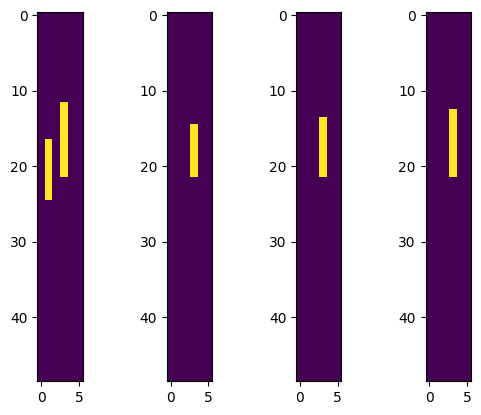

In [ ]:
i=1
plt.subplot(141)
plt.imshow(edges_t[i].cpu().numpy())

plt.subplot(142)
plt.imshow(ep[i])

plt.subplot(143)
plt.imshow(ec[i]);
plt.subplot(144)
plt.imshow(el[i,...,1]);

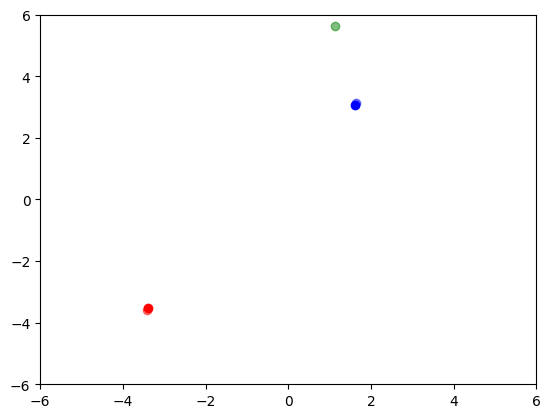

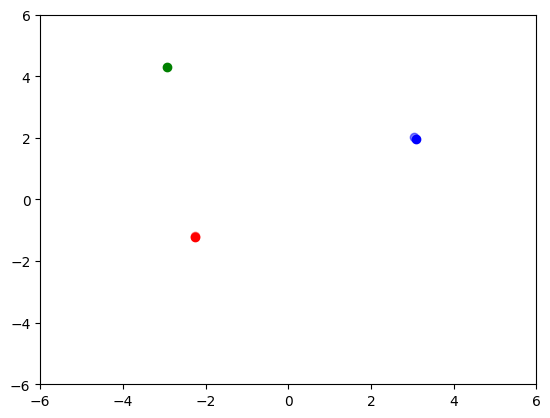

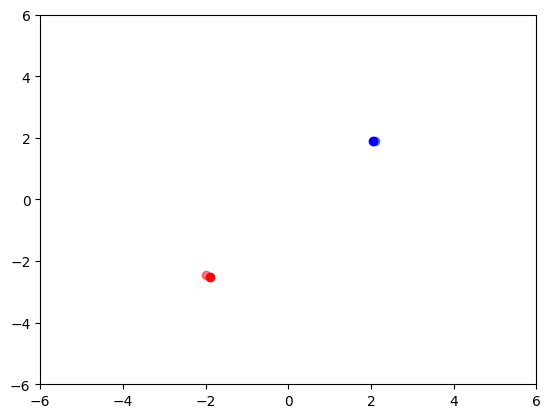

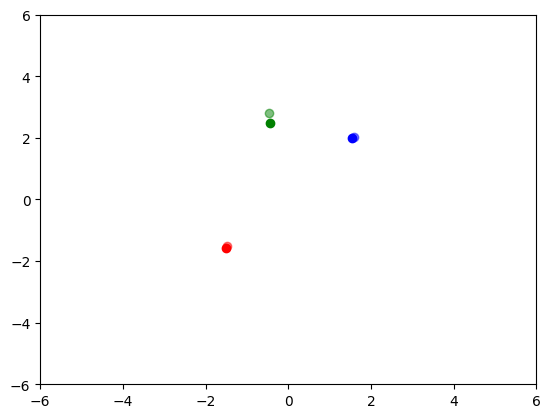

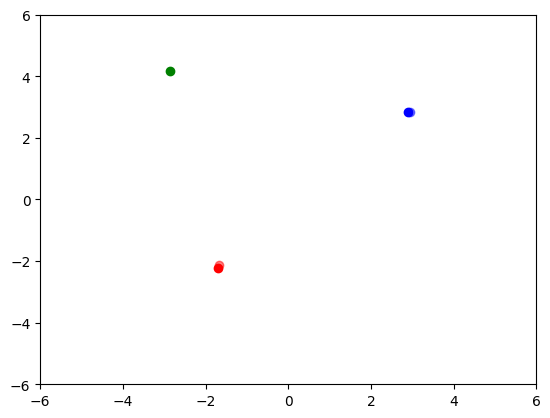

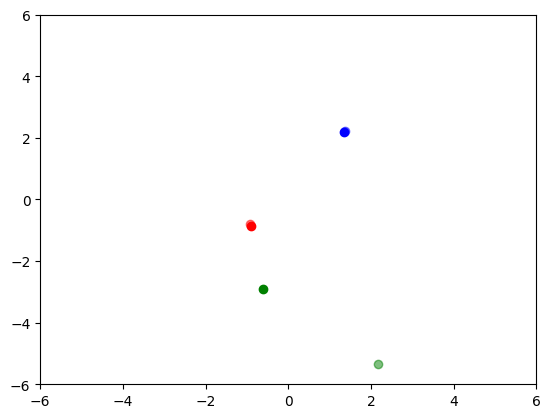

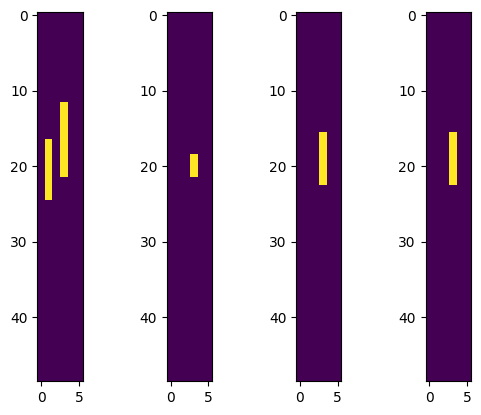

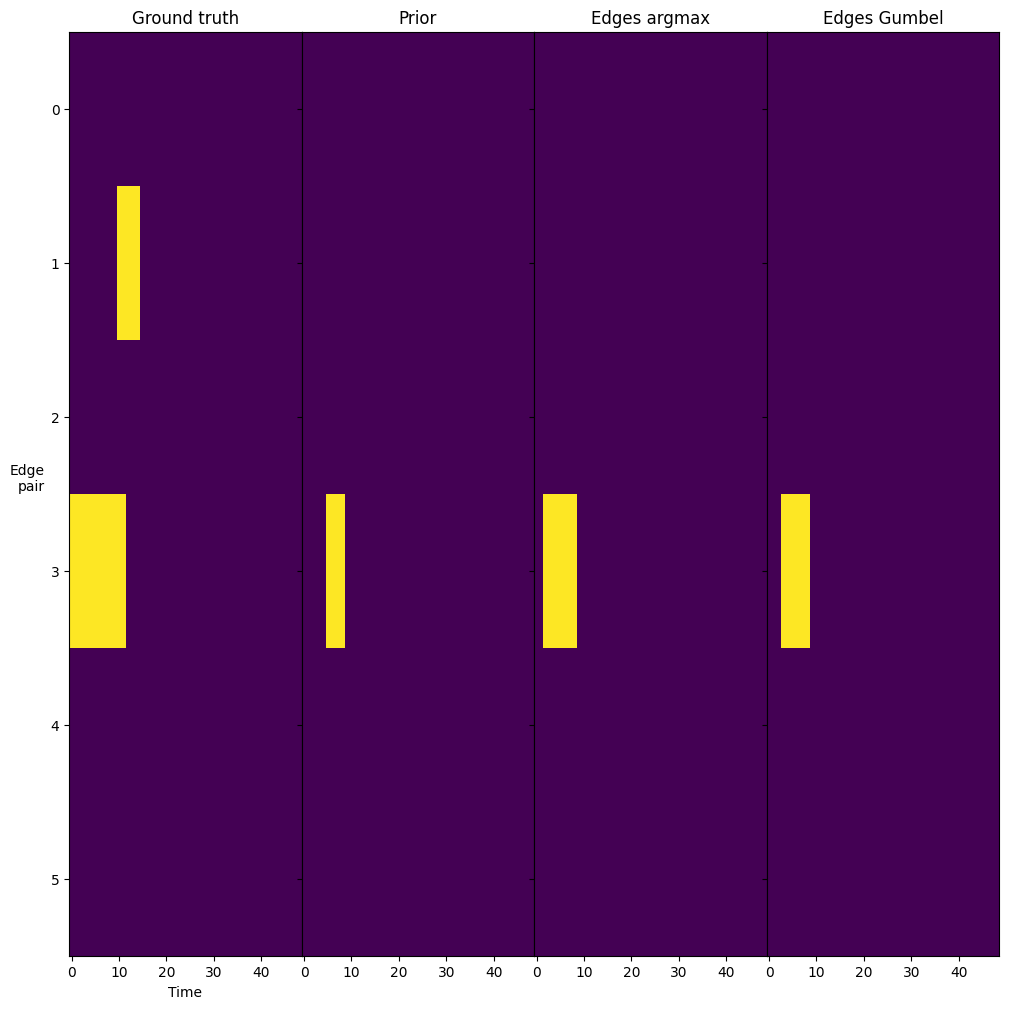

In [ ]:
i=3 # timeseries sample
fig, axs = plt.subplots(1,4, sharey=True,
                        figsize=(12,12), gridspec_kw=dict(wspace=0))
axs[0].imshow(edges_t[i,].cpu().numpy().T,aspect='auto', vmin=0,vmax=1)
axs[0].set_xlabel('Time'); axs[0].set_ylabel('Edge\npair', rotation=0, ha='right')
axs[0].set_title('Ground truth')

axs[1].imshow(ep[i].T,aspect='auto', vmin=0,vmax=1)
axs[1].set_title('Prior')

axs[2].imshow(ec[i].T,aspect='auto', vmin=0,vmax=1);
axs[2].set_title('Edges argmax')

axs[3].imshow(el[i,...,1].T,aspect='auto', vmin=0,vmax=1);
axs[3].set_title('Edges Gumbel');